In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# EXAMPLE 1 WEIGHTING THE GOLD

## Predicting the hidden state of a system with a static dynamic model with an α filter

Predict the weight of a gold bar over repeated measurements

![ex1_state_update equation](../images/ex1_ExampleNotation.png)

![ex1 estimation algorithm with alpha filter](../images/ex1_estimationAlgorithm.png)

## State Estimation Equation

$\hat{x}_{n+1,n}=\hat{x}_{n,n}$

## State Update Equation

$\hat{x}_{n,n}=\hat{x}_{n,n-1} + \frac{1}{n}(z_{n} - \hat{x}_{n,n-1})$

## System represented by a gold bar

The system is modelled by a static dynamic equation since its weight doesn't change over time. The true weight is 1000g. Our measurements will be spread around this value due to random measurement/precision errors with a normal distribution.

In [16]:
# true weight
x_true = 1000

# state estimation equation
state_est_weight = lambda x: x

# state update equation
state_update_weight = lambda x,z,n: x + (1/n) * (z - x)

In [17]:
uncertainty_mult = 50
nt = 50  # num of measurements
x_init = 1000

x_measures = [x_true + (np.random.normal() * uncertainty_mult) for _ in range(nt)]
x_trues = [x_true] * nt
x_estimations = [x_init]  # initial pred is the initial guess
x_n_minus_one = x_init
for n in range(1, nt):  # at 0th step we use the initial guess
    x_est = state_update_weight(x_n_minus_one, x_measures[n], n)
    x_n_plus_one = state_est_weight(x_est)

    x_estimations.append(x_est)
    
    x_n_minus_one = x_n_plus_one

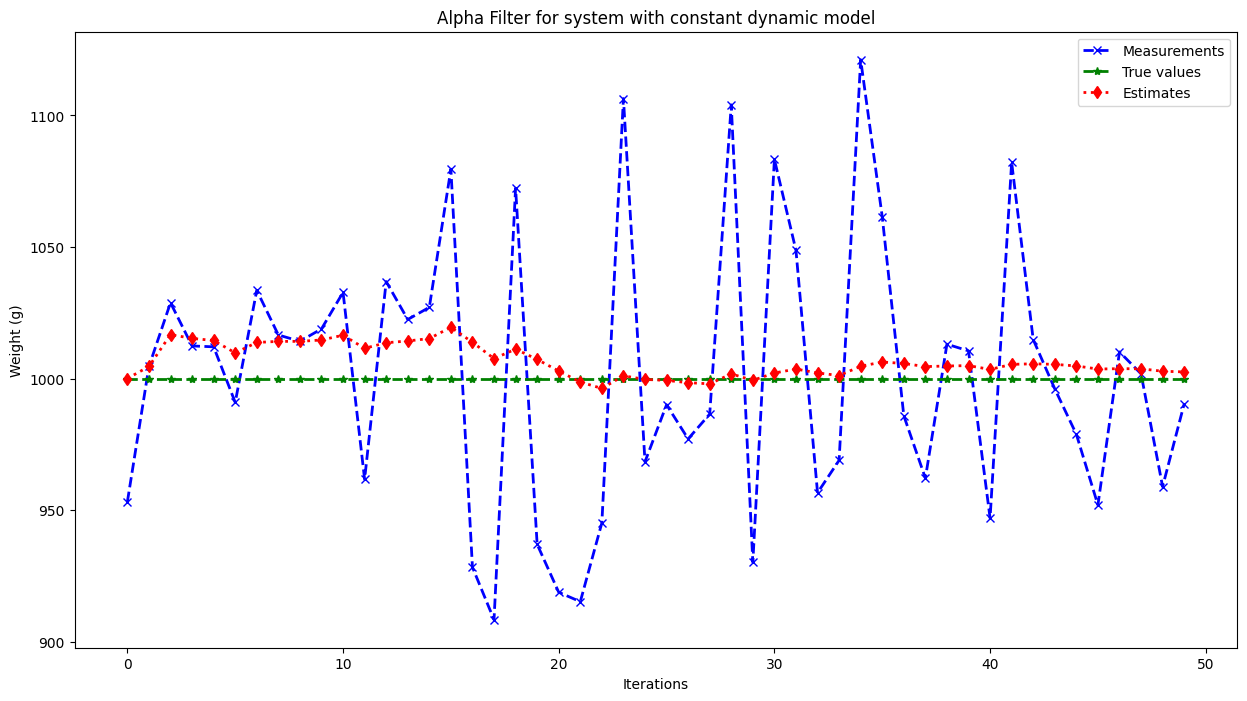

In [20]:
plt.figure(figsize=(15, 8))

plt.title(label="Alpha Filter for system with constant dynamic model")
plt.plot(x_measures, color='blue', marker='x', linestyle='dashed', linewidth=2, label="Measurements")
plt.plot(x_trues, color='green', marker='*', linestyle='--', linewidth=2, label="True values")
plt.plot(x_estimations, color='red', marker='d', linestyle='dotted', linewidth=2, label="Estimates")

plt.xlabel("Iterations")
plt.ylabel("Weight (g)")
plt.legend()
plt.show()

# EXAMPLE 2 TRACKING THE CONSTANT VELOCITY AIRCRAFT IN ONE DIMENSION

## Predicting the hidden state of a system with a dynamic model with an α filter

Predict the location and velocity of an aircraft moving with constant speed

![radar](../images/ex2_oneD_radar.png)

![est2](../images/ex2_estimationAlgorithm.png)

## State Estimation Equation

Distance: $\hat{x}_{n+1,n}=\hat{x}_{n,n} + (\Delta t * \hat{\dot{x}}_{n,n})$

Velocity: $\hat{\dot{x}}_{n+1,n}=\hat{\dot{x}}_{n,n}$

## State Update Equation

Distance: $\hat{x}_{n,n}=\hat{x}_{n,n-1} + \alpha (z_{n} - \hat{x}_{n,n-1})$

Velocity: $\hat{\dot{x}}_{n,n}=\hat{\dot{x}}_{n,n-1} + \beta (\frac{z_{n} - \hat{x}_{n,n-1}}{\Delta t})$

In [44]:
# alpha and beta (Kalman gain factors) Higher values mean more precise instrument measures
alpha = 0.2
beta = 0.1
dt = 5  # radar track-to-track interval in s

uncertainty_mult = 100
nt = 15  # num of measurements
init_dist = 30000
init_vel = 40

# state estimation equations
state_est_distance = lambda x,t,v: x + (t*v) 
state_est_velocity = lambda v: v

# state update equations
state_update_distance = lambda x,z,n: x + (alpha * (z - x))
state_update_velocity = lambda v,x,z,t,n: v + (beta * ((z - x) / t))

In [47]:
dist_trues = [init_dist + (init_vel*i*5) for i in range(nt)]
dist_measures = [dist + (np.random.normal() * uncertainty_mult) for dist in dist_trues]

vel_estimates = [init_vel]
dist_estimates = [init_dist]
dist_preds = [init_dist, state_est_distance(init_dist, dt, init_vel)]

dist_n_minus_one = init_dist
vel_n_minus_one = init_vel

for n in range(1, nt):  # at 0th step we use the initial guess
    dist_est = state_update_distance(dist_n_minus_one, dist_measures[n], n)
    vel_est = state_update_velocity(vel_n_minus_one, dist_n_minus_one, dist_measures[n], dt, n)
    
    dist_n_plus_one = state_est_distance(dist_est, dt, vel_est)
    vel_n_plus_one = state_est_velocity(vel_est)
    
    dist_estimates.append(dist_est)
    vel_estimates.append(vel_est)
    dist_preds.append(dist_n_plus_one)
    # After a unit time delay, the pred estimate from the previous iteration becomes the prior estimate in the current iteration
    dist_n_minus_one = dist_n_plus_one
    vel_n_minus_one = vel_n_plus_one

dist_preds.pop()  # drop the last prediction

32984.56712171458

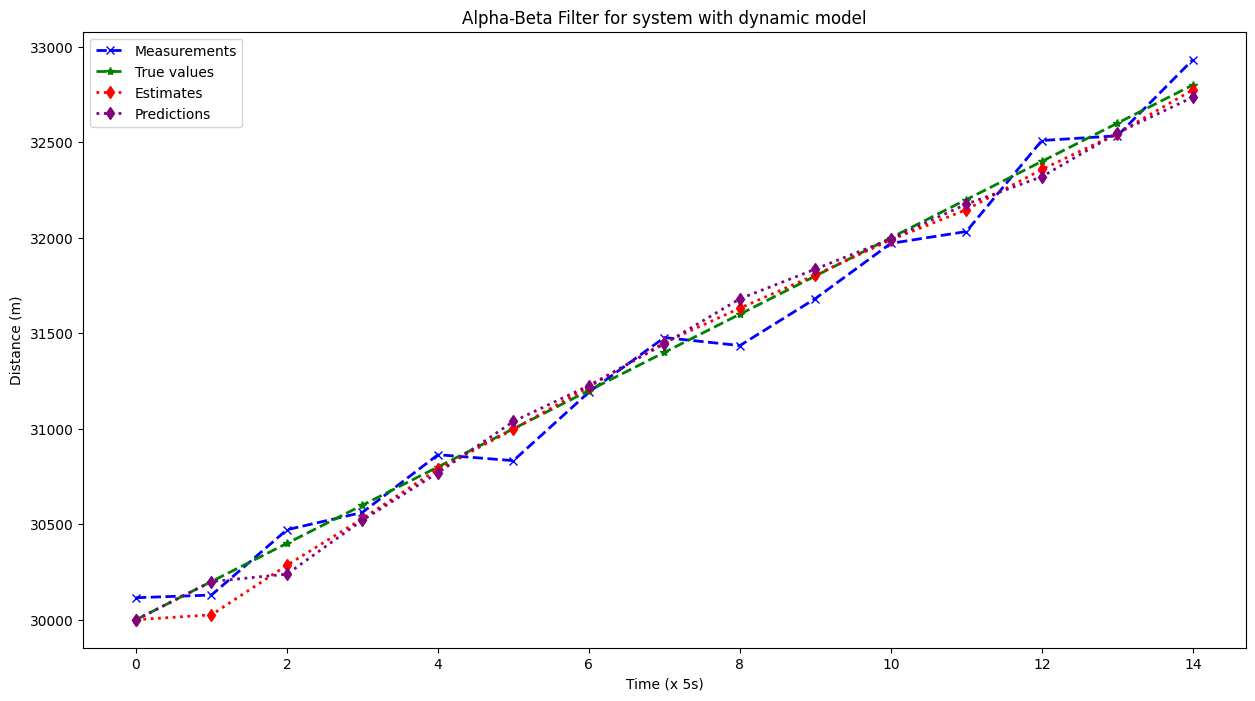

In [48]:
plt.figure(figsize=(15, 8))

plt.title(label="Alpha-Beta Filter for system with dynamic model")
plt.plot(dist_measures, color='blue', marker='x', linestyle='dashed', linewidth=2, label="Measurements")
plt.plot(dist_trues, color='green', marker='*', linestyle='--', linewidth=2, label="True values")
plt.plot(dist_estimates, color='red', marker='d', linestyle='dotted', linewidth=2, label="Estimates")
plt.plot(dist_preds, color='purple', marker='d', linestyle='dotted', linewidth=2, label="Predictions")

plt.xlabel("Time (x 5s)")
plt.ylabel("Distance (m)")
plt.legend()
plt.show()

# EXAMPLE 3  TRACKING ACCELERATING AIRCRAFT IN ONE DIMENSION

## Predicting the hidden state of a system with a dynamic model with an α-β filter

Predict the location and velocity of an aircraft moves with a constant speed and accelerates after a while

## State Estimation Equation

Distance: $\hat{x}_{n+1,n}=\hat{x}_{n,n} + (\Delta t * \hat{\dot{x}}_{n,n})$

Velocity: $\hat{\dot{x}}_{n+1,n}=\hat{\dot{x}}_{n,n}$

## State Update Equation

Distance: $\hat{x}_{n,n}=\hat{x}_{n,n-1} + \alpha (z_{n} - \hat{x}_{n,n-1})$

Velocity: $\hat{\dot{x}}_{n,n}=\hat{\dot{x}}_{n,n-1} + \beta (\frac{z_{n} - \hat{x}_{n,n-1}}{\Delta t})$

## Note

We will observer a systematic error in our estimates known as the lag error due to the target acceleration

### Example 2 Constant Velocity and no acceleration

![est2](../images/ex3_constantVelocityMovement.png)

### Example 3 Changing Velocity

![est2](../images/ex3_acceleratedMovement.png)

In [78]:
# alpha and beta (Kalman gain factors) Higher values mean more precise instrument measures
alpha = 0.2
beta = 0.1
dt = 5  # radar track-to-track interval in s

uncertainty_mult = 100
nt = 10  # num of measurements
init_dist = 30000
init_vel = 50
init_acc = 0

# state estimation equations
state_est_distance = lambda x,t,v: x + (t*v) 
state_est_velocity = lambda v: v

# state update equations
state_update_distance = lambda x,z,n: x + (alpha * (z - x))
state_update_velocity = lambda v,x,z,t,n: v + (beta * ((z - x) / t))

In [79]:
acc_trues = [init_acc for _ in range(nt//2)] + [8 for _ in range(nt//2)]

vel_trues = []
prev_vel = init_vel
for i in range(nt):
    cur_vel = prev_vel + acc_trues[i]*5
    vel_trues.append(cur_vel)
    prev_vel = cur_vel

dist_trues = []
prev_dist = init_dist
for i in range(nt):
    cur_dist = prev_dist + vel_trues[i]*5
    dist_trues.append(cur_dist)
    prev_dist = cur_dist

dist_measures = [dist + (np.random.normal() * uncertainty_mult) for dist in dist_trues]

vel_estimates = [init_vel]
dist_estimates = [init_dist]
dist_preds = [init_dist, state_est_distance(init_dist, dt, init_vel)]

dist_n_minus_one = init_dist
vel_n_minus_one = init_vel

for n in range(1, nt):  # at 0th step we use the initial guess
    dist_est = state_update_distance(dist_n_minus_one, dist_measures[n], n)
    vel_est = state_update_velocity(vel_n_minus_one, dist_n_minus_one, dist_measures[n], dt, n)
    
    dist_n_plus_one = state_est_distance(dist_est, dt, vel_est)
    vel_n_plus_one = state_est_velocity(vel_est)
    
    dist_estimates.append(dist_est)
    vel_estimates.append(vel_est)
    dist_preds.append(dist_n_plus_one)
    # After a unit time delay, the pred estimate from the previous iteration becomes the prior estimate in the current iteration
    dist_n_minus_one = dist_n_plus_one
    vel_n_minus_one = vel_n_plus_one

dist_preds.pop()  # drop the last prediction

35017.22340250675

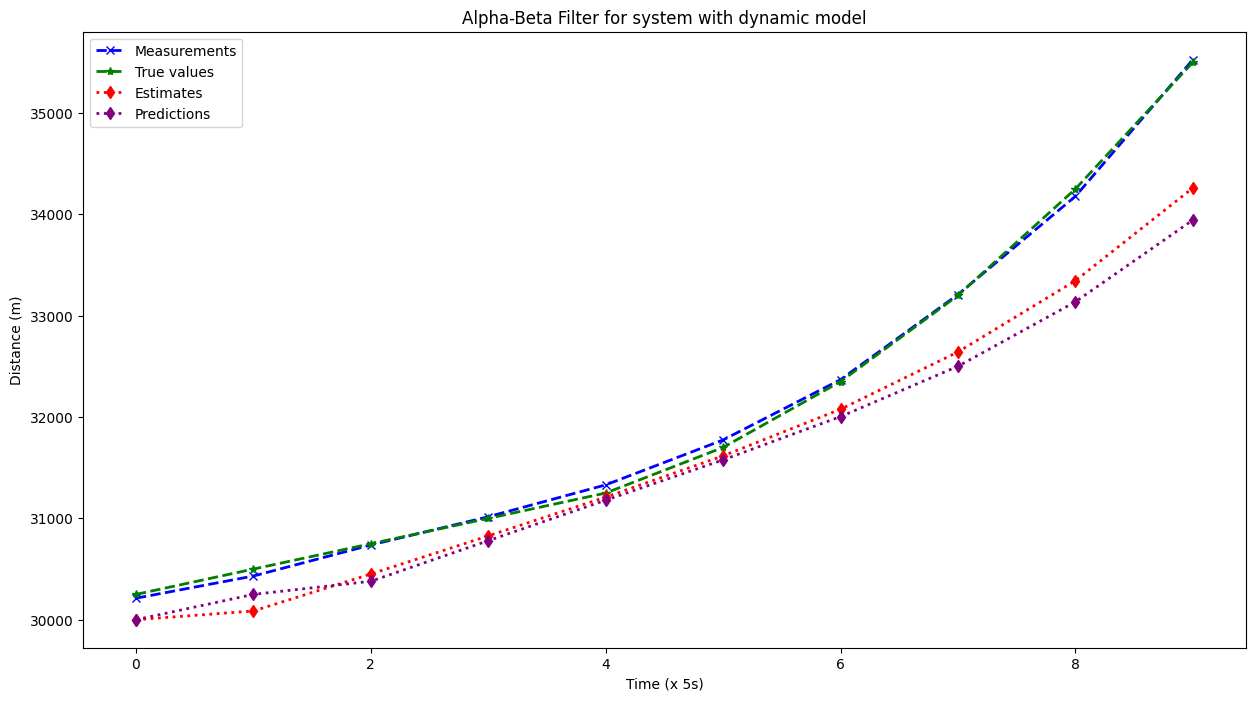

In [80]:
plt.figure(figsize=(15, 8))

plt.title(label="Alpha-Beta Filter for system with dynamic model")
plt.plot(dist_measures, color='blue', marker='x', linestyle='dashed', linewidth=2, label="Measurements")
plt.plot(dist_trues, color='green', marker='*', linestyle='--', linewidth=2, label="True values")
plt.plot(dist_estimates, color='red', marker='d', linestyle='dotted', linewidth=2, label="Estimates")
plt.plot(dist_preds, color='purple', marker='d', linestyle='dotted', linewidth=2, label="Predictions")

plt.xlabel("Time (x 5s)")
plt.ylabel("Distance (m)")
plt.legend()
plt.show()

# EXAMPLE 4 TRACKING ACCELERATING AIRCRAFT WITH THE α−β−γ FILTER

## Predicting the hidden state of a system with a dynamic model with an α−β−γ filter

Predict the location and velocity of an aircraft moving with constant acceleration

## State Estimation Equation

Distance: $\hat{x}_{n+1,n}=\hat{x}_{n,n} + (\Delta t * \hat{\dot{x}}_{n,n})$

Velocity: $\hat{\dot{x}}_{n+1,n}=\hat{\dot{x}}_{n,n} + (\Delta t * \hat{\ddot{x}}_{n,n})$

Acceleration: $\hat{\ddot{x}}_{n+1,n}=\hat{\ddot{x}}_{n,n}$

## State Update Equation

Distance: $\hat{x}_{n,n}=\hat{x}_{n,n-1} + \alpha (z_{n} - \hat{x}_{n,n-1})$

Velocity: $\hat{\dot{x}}_{n,n}=\hat{\dot{x}}_{n,n-1} + \beta (\frac{z_{n} - \hat{x}_{n,n-1}}{\Delta t})$

Acceleration: $\hat{\ddot{x}}_{n,n}=\hat{\ddot{x}}_{n,n-1} + \gamma (\frac{z_{n} - \hat{x}_{n,n-1}}{\Delta t^{2}})$

In [81]:
# alpha, beta, and gamma (Kalman gain factors) Higher values mean more precise instrument measures
alpha = 0.2
beta = 0.1
gamma = 0.1
dt = 5  # radar track-to-track interval in s

uncertainty_mult = 100
nt = 10  # num of measurements
init_dist = 30000
init_vel = 50
init_acc = 0

# state estimation equations
state_est_distance = lambda x,t,v: x + (t*v) 
state_est_velocity = lambda v,t,a: v + (t*a)
state_est_acceleration = lambda a: a

# state update equations
state_update_distance = lambda x,z,n: x + (alpha * (z - x))
state_update_velocity = lambda v,x,z,t,n: v + (beta * ((z - x) / t))
state_update_acceleration = lambda a,x,z,t,n: a + (gamma * ((z - x) / (t**2)))

In [82]:
acc_trues = [init_acc for _ in range(nt//2)] + [8 for _ in range(nt//2)]

vel_trues = []
prev_vel = init_vel
for i in range(nt):
    cur_vel = prev_vel + acc_trues[i]*5
    vel_trues.append(cur_vel)
    prev_vel = cur_vel

dist_trues = []
prev_dist = init_dist
for i in range(nt):
    cur_dist = prev_dist + vel_trues[i]*5
    dist_trues.append(cur_dist)
    prev_dist = cur_dist

dist_measures = [dist + (np.random.normal() * uncertainty_mult) for dist in dist_trues]

dist_estimates = [init_dist]
vel_estimates = [init_vel]
acc_estimates = [init_acc]
dist_preds = [init_dist, state_est_distance(init_dist, dt, init_vel)]
vel_preds = [init_vel, state_est_velocity(init_vel, dt, init_acc)]
acc_preds = [init_acc, state_est_acceleration(init_acc)]

dist_n_minus_one = init_dist
vel_n_minus_one = init_vel
acc_n_minus_one = init_acc

for n in range(1, nt):  # at 0th step we use the initial guess
    dist_est = state_update_distance(dist_n_minus_one, dist_measures[n], n)
    vel_est = state_update_velocity(vel_n_minus_one, dist_n_minus_one, dist_measures[n], dt, n)
    acc_est = state_update_acceleration(acc_n_minus_one, dist_n_minus_one, dist_measures[n], dt, n)

    # predictions
    dist_n_plus_one = state_est_distance(dist_est, dt, vel_est)
    vel_n_plus_one = state_est_velocity(vel_est, dt, acc_est)
    acc_n_plus_one = state_est_acceleration(acc_est)
    
    dist_estimates.append(dist_est)
    vel_estimates.append(vel_est)
    acc_estimates.append(acc_est)
    dist_preds.append(dist_n_plus_one)
    vel_preds.append(vel_n_plus_one)
    
    # After a unit time delay, the pred estimate from the previous iteration becomes the prior estimate in the current iteration
    dist_n_minus_one = dist_n_plus_one
    vel_n_minus_one = vel_n_plus_one
    acc_n_minus_one = acc_n_plus_one

dist_preds.pop()  # drop the last prediction

35992.76119704726

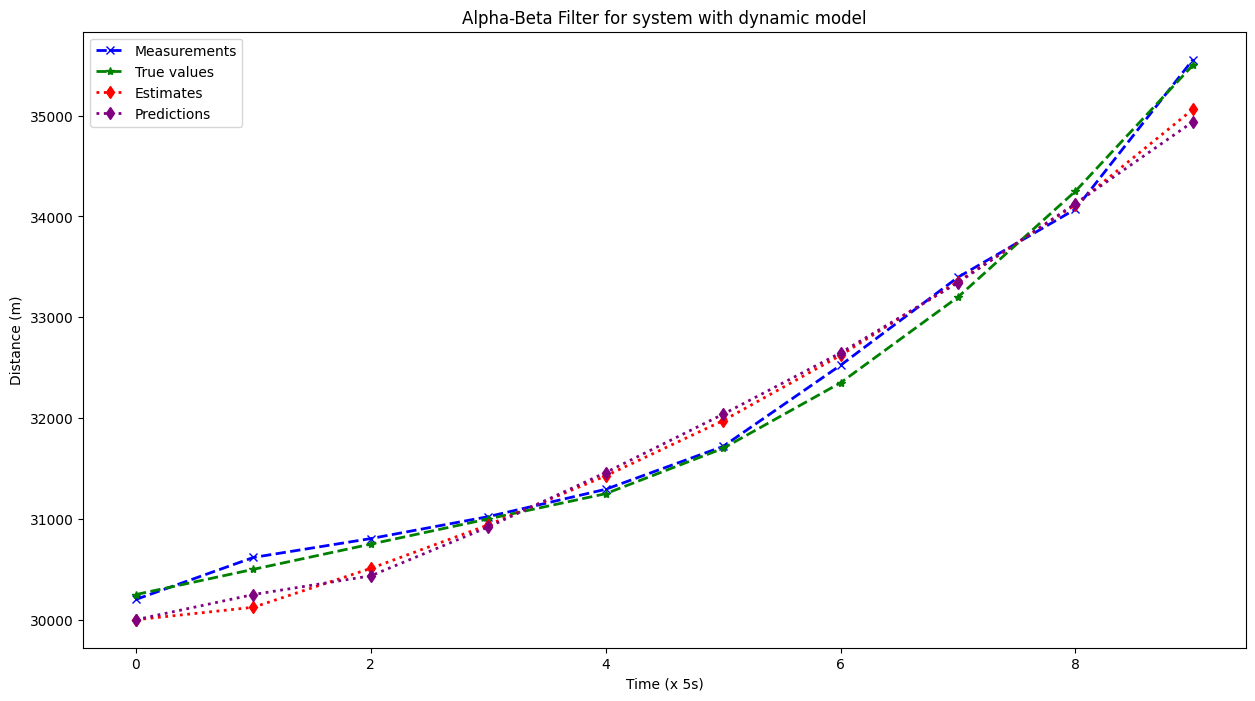

In [84]:
plt.figure(figsize=(15, 8))

plt.title(label="Alpha-Beta Filter for system with dynamic model")
plt.plot(dist_measures, color='blue', marker='x', linestyle='dashed', linewidth=2, label="Measurements")
plt.plot(dist_trues, color='green', marker='*', linestyle='--', linewidth=2, label="True values")
plt.plot(dist_estimates, color='red', marker='d', linestyle='dotted', linewidth=2, label="Estimates")
plt.plot(dist_preds, color='purple', marker='d', linestyle='dotted', linewidth=2, label="Predictions")

plt.xlabel("Time (x 5s)")
plt.ylabel("Distance (m)")
plt.legend()
plt.show()

# References

i. [Kalman Filter Tutorial by Alex Becker](https://www.kalmanfilter.net/default.aspx)